In [1]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import keplergl
from tqdm import tqdm
import matplotlib.pyplot as plt
import h3
import re
from geopy import Nominatim, location
from geopy.extra.rate_limiter import RateLimiter
import googlemaps
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro, fligner

In [24]:
# Not standard
prev_df_bc = pd.read_csv('datasets/analyzed_data/clean_after_null_and_outliers_with_boxcox.csv')
prev_df_bc.drop(['price_per_m2', 'sq_mt_useful'], axis=1, inplace=True)
prev_df_bc.drop('Unnamed: 0', axis=1, inplace=True)
# Standard
prev_df_nobc = pd.read_csv('datasets/analyzed_data/clean_after_null_and_outliers_without_boxcox.csv')
prev_df_nobc.drop(['price_per_m2', 'sq_mt_useful'], axis=1, inplace=True)
prev_df_nobc.drop('Unnamed: 0', axis=1, inplace=True)



In [25]:
prev_df_bc.describe()

,sq_mt_built,n_rooms,n_bathrooms,floor,is_floor_under,is_renewal_needed,is_new_development,has_ac,has_fitted_wardrobes,has_lift,is_exterior,has_terrace,has_storage_room,has_parking,zip_codes_count,hosts_distribution_per_zip_code,average_reviews_per_month_per_code,buy_for_rent_ratio,buy_price
count,7564.000000,7564.000000,7.564000e+03,7.564000e+03,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7.564000e+03
mean,0.001366,-0.014747,-1.878749e-17,1.315124e-16,0.142385,0.210603,0.049841,0.458884,0.631941,0.721179,0.886171,0.401507,0.257932,0.237837,387.818879,0.004901,-0.000523,0.003492,3.615209e+05
std,0.992948,0.952744,1.000066e+00,1.000066e+00,0.349468,0.407764,0.217631,0.498340,0.482309,0.448449,0.317624,0.490236,0.437525,0.425787,433.297065,0.984044,0.868192,0.985977,2.542246e+05
min,-2.753111,-2.142881,-9.145531e-01,-1.739655e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,-2.619770,-1.849932,-2.731221,4.200000e+04
25%,-0.696606,-0.647233,-9.145531e-01,-7.189316e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,167.000000,-0.620014,-0.496756,-0.683176,1.700000e+05
50%,-0.045484,0.349866,-9.145531e-01,-5.210316e-02,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,327.000000,-0.068483,0.109042,-0.049782,2.750000e+05
75%,0.674398,0.349866,9.170033e-01,8.696511e-01,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,439.000000,0.713157,0.405361,0.682187,4.790000e+05
max,2.730904,1.845514,2.333429e+00,2.282727e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3443.000000,2.712913,1.758537,2.730232,1.375000e+06


In [26]:
prev_df_nobc.describe()

,sq_mt_built,n_rooms,n_bathrooms,floor,is_floor_under,is_renewal_needed,is_new_development,has_ac,has_fitted_wardrobes,has_lift,is_exterior,has_terrace,has_storage_room,has_parking,zip_codes_count,hosts_distribution_per_zip_code,average_reviews_per_month_per_code,buy_for_rent_ratio,buy_price
count,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7564.000000,7.564000e+03
mean,95.663141,2.680130,1.558567,2.509981,0.142385,0.210603,0.049841,0.458884,0.631941,0.721179,0.886171,0.401507,0.257932,0.237837,387.818879,0.259881,24.534166,0.368700,3.615209e+05
std,40.606261,0.934792,0.666341,1.950989,0.349468,0.407764,0.217631,0.498340,0.482309,0.448449,0.317624,0.490236,0.437525,0.425787,433.297065,0.072137,4.891074,0.105624,2.542246e+05
min,16.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.067314,13.905430,0.079811,4.200000e+04
25%,65.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,167.000000,0.213836,21.619672,0.292667,1.700000e+05
50%,85.000000,3.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,327.000000,0.254011,24.969863,0.353889,2.750000e+05
75%,117.000000,3.000000,2.000000,4.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,439.000000,0.311518,26.762500,0.434572,4.790000e+05
max,195.000000,4.500000,3.500000,8.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3443.000000,0.458041,34.476742,0.647428,1.375000e+06


A partir de aquí seguimos con el conjunto estandarizado. En null_and_outliers se ha realizado un análisis de la normalidad con shapiro-wilk, viendo que los datos no siguen una distribución normal. Se ha realizado una transformación box-cox, que mejora ligeramente los resultados, pero siguen sin tener una distribución normal pues todos los p-valores están por debajo de 0.05.

In [27]:
# Se analizan las variables no binarias
bin = []
not_bin = []

for c in prev_df_nobc.columns.to_list():
    if set(prev_df_nobc[c].unique()) == {0, 1}:
        bin.append(c)
    elif c!='latitude' and c!='longitude' and c!='zip_code': # we're not analyzing location, it's implicit into some variables, but we're using it later
        not_bin.append(c)

In [28]:
def plot_linear_regression(df: pd.DataFrame, target:str)-> None:
    col = df.columns
    row_number = (len(col) // 3) + (1 if len(col) % 3 != 0 else 0)
    col_number = 3

    # Subplots
    fig, axes = plt.subplots(row_number, 3, figsize=(15, 5*row_number))
    # fig.subplots_adjust(hspace=0.5)

    # Iter through cols
    for i, column in enumerate(col):
        fila = i // col_number
        col_subplot = i % col_number

        if row_number > 1:
            ax = axes[fila, col_subplot]
        else:
            ax = axes[col_subplot]

        sns.regplot(x=column, y=target, data=df, ax=ax)
        ax.set_xlabel(column)
        ax.set_ylabel(target)

    # Adjust subplot spacing
    fig.tight_layout()

    plt.show()

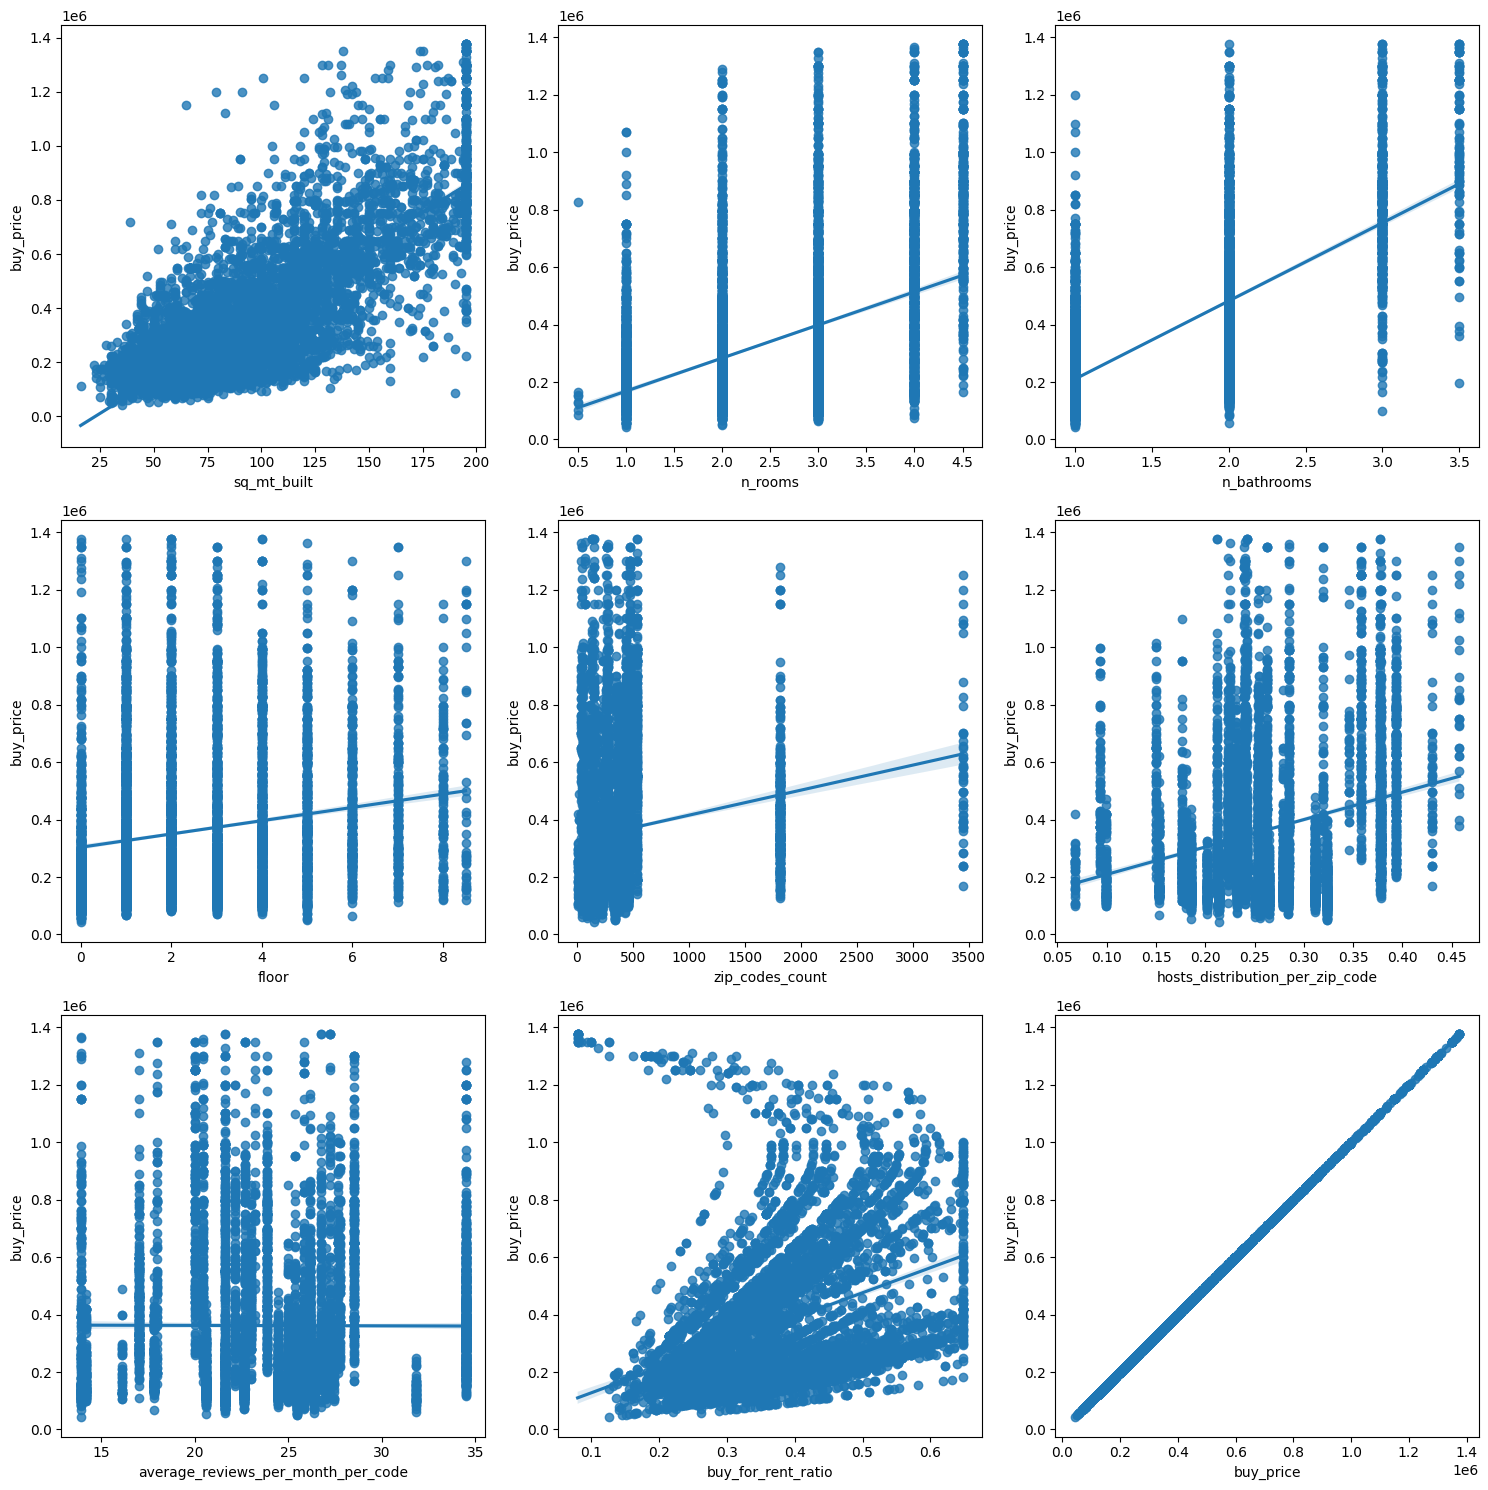

In [29]:
plot_linear_regression(prev_df_nobc[not_bin], 'buy_price')

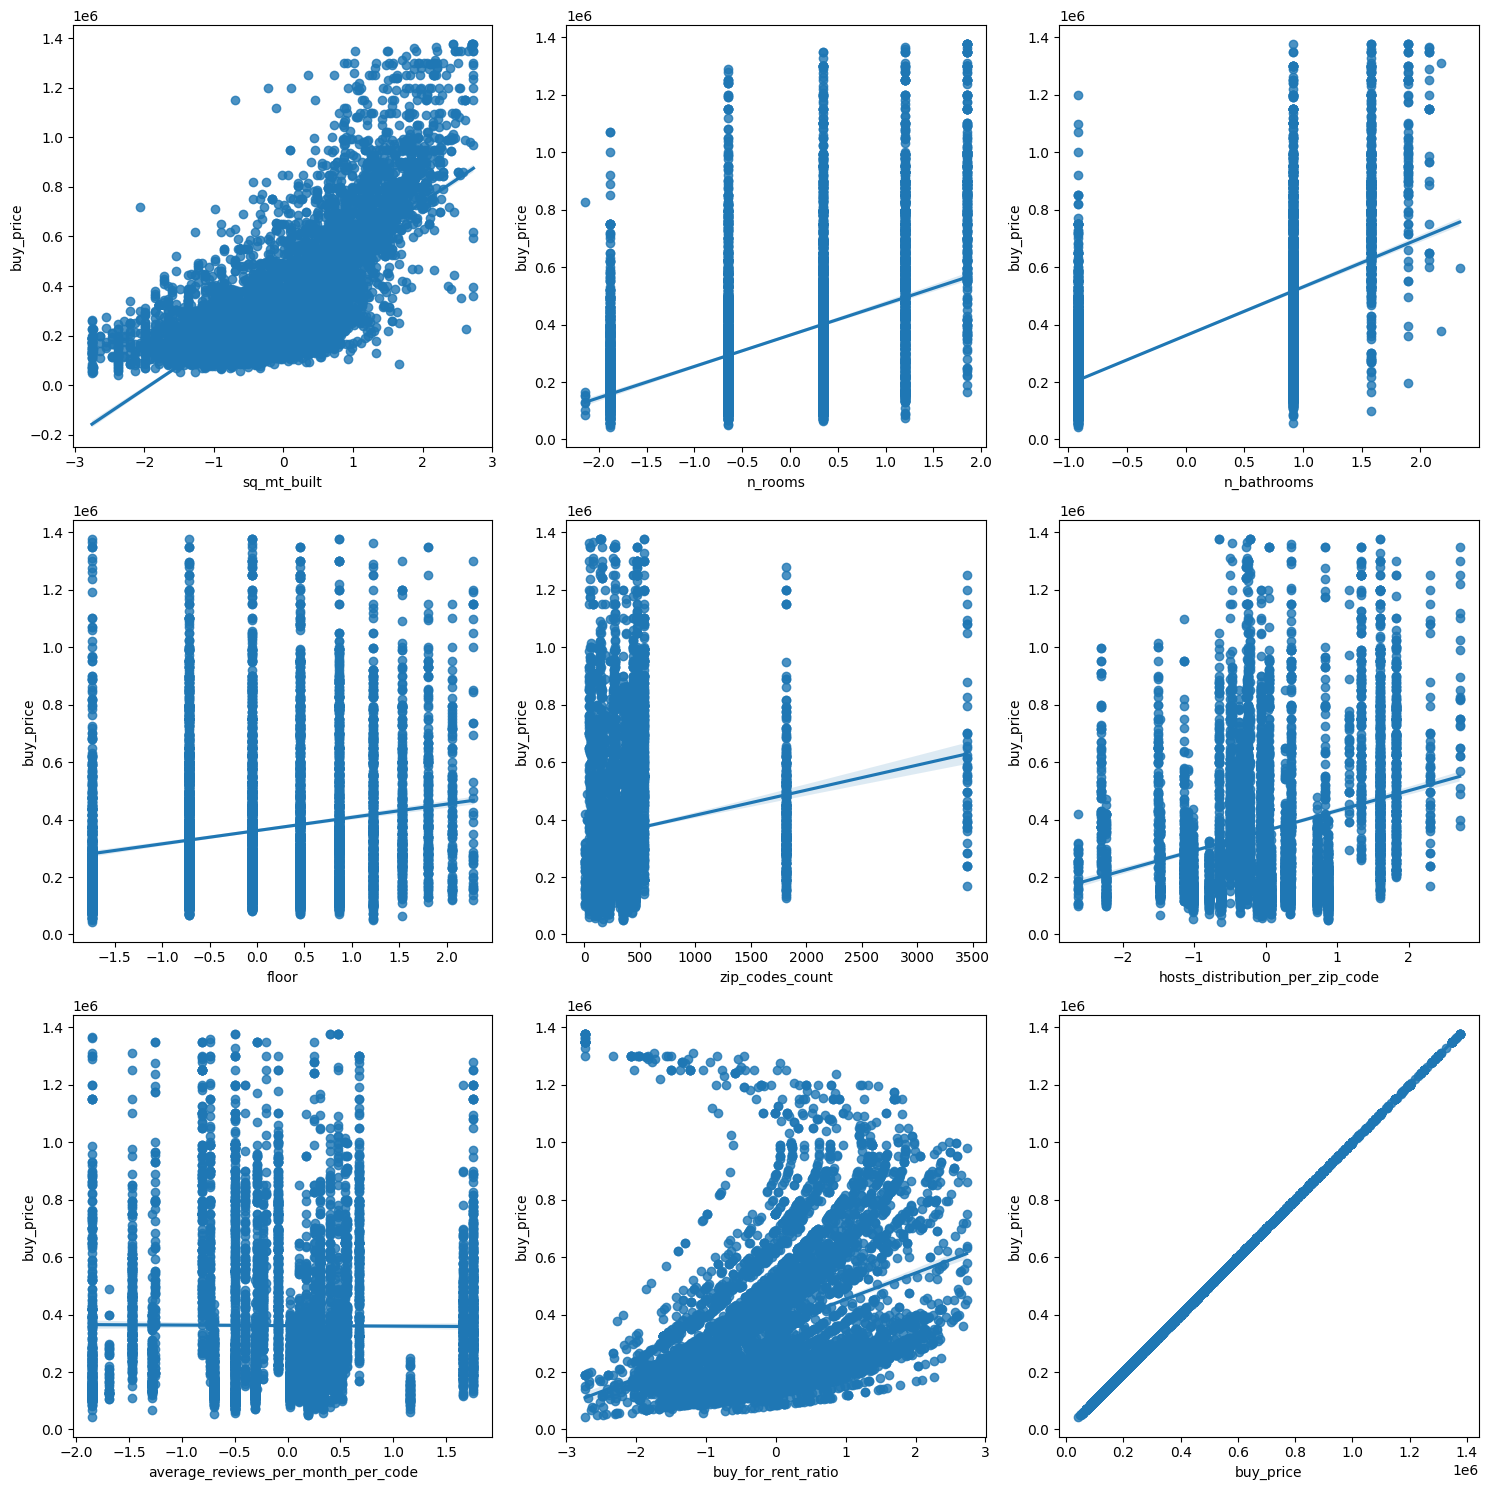

In [31]:
plot_linear_regression(prev_df_bc[not_bin], 'buy_price')

Como se puede ver, aparece mucha dispersión para todas las variables

In [33]:
target = prev_df_nobc['buy_price']
prev_df_nobc.drop('buy_price', axis=1, inplace=True)
target_bc = prev_df_bc['buy_price']
prev_df_bc.drop('buy_price', axis=1, inplace=True)

In [34]:
# Data division
from sklearn.preprocessing import StandardScaler
train_std_x, test_std_x, train_std_y, test_std_y = train_test_split(prev_df_nobc, target, test_size=0.2, random_state=42)
scaler = StandardScaler()
cols = prev_df_nobc.columns.to_list()
for col in cols:
    train_std_x[col]=scaler.fit_transform(train_std_x[[col]])
    test_std_x[col]=scaler.transform(test_std_x[[col]])

Scikit-learn

In [35]:
import math
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import SGD

In [36]:
# Regresión Lineal para datos sin transformar
scores = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
kfold = sklearn.model_selection.KFold(n_splits=10)
lin_reg_model = LinearRegression()
lin_reg = sklearn.model_selection.cross_validate(
    lin_reg_model,
    train_std_x,
    train_std_y,
    scoring=scores,
    cv=kfold
)
print(
    f"{lin_reg['fit_time'].mean():.3f}s  R2: "
    f"{lin_reg['test_r2'].mean():.3f}  MAE: "
    f"{lin_reg['test_neg_mean_absolute_error'].mean()*-1:.3f}  RMSE: "
    f"{math.sqrt(lin_reg['test_neg_mean_squared_error'].mean()*-1):.3f}"
)

0.014s  R2: 0.765  MAE: 89506.619  RMSE: 122575.095


Hacemos una comparación de lo que ocurre si se utilizan los datos tras la transformación box-cox

In [37]:
# Data division with boxcox
train_std_x_bc, test_std_x_bc, train_std_y_bc, test_std_y_bc = train_test_split(prev_df_bc, target, test_size=0.2, random_state=42)
scaler_bc = StandardScaler()
cols = prev_df_bc.columns.to_list()
for col in cols:
    train_std_x_bc[col]=scaler_bc.fit_transform(train_std_x_bc[[col]])
    test_std_x_bc[col]=scaler_bc.transform(test_std_x_bc[[col]])

In [38]:
# Linear regression for box-cox transformed data
scores_bc = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
kfold_bc = sklearn.model_selection.KFold(n_splits=10)
lin_reg_model_bc = LinearRegression()
lin_reg_bc = sklearn.model_selection.cross_validate(
    lin_reg_model_bc,
    train_std_x_bc,
    train_std_y_bc,
    scoring=scores_bc,
    cv=kfold_bc
)
print(
    f"{lin_reg['fit_time'].mean():.3f}s  R2: "
    f"{lin_reg['test_r2'].mean():.3f}  MAE: "
    f"{lin_reg['test_neg_mean_absolute_error'].mean()*-1:.3f}  RMSE: "
    f"{math.sqrt(lin_reg['test_neg_mean_squared_error'].mean()*-1):.3f}"
)

0.014s  R2: 0.765  MAE: 89506.619  RMSE: 122575.095


Ahora analizamos los datos desde la perspectiva de un xgboost regressor, primero para datos sin transformar y después para datos transformados

In [39]:
# xgboost
xgb_model = xgb.XGBRegressor()
xgb_model_ = sklearn.model_selection.cross_validate(
    xgb_model,
    train_std_x,
    train_std_y,
    scoring=scores,
    cv=kfold
)
print(
    f"{xgb_model_['fit_time'].mean():.3f}s  R2: "
    f"{xgb_model_['test_r2'].mean():.3f}  MAE: "
    f"{xgb_model_['test_neg_mean_absolute_error'].mean()*-1:.3f}  RMSE: "
    f"{math.sqrt(xgb_model_['test_neg_mean_squared_error'].mean()*-1):.3f}"
)

# hyperparameters optimization
params = {
    'max_depth': [5,10,20,40],
    'n_estimators': [10,20,40,80],
    'learning_rate': [0.1,0.01]
}
xgrid = GridSearchCV(estimator=xgb.XGBRegressor(),           
                      param_grid=params, 
                      cv=5,
                      verbose=0) 
xgrid.fit(train_std_x, train_std_y)
print(xgrid.best_score_)
print(xgrid.best_estimator_)
print(xgrid.best_params_)

0.738s  R2: 0.941  MAE: 31384.134  RMSE: 61278.516
0.9384156111483101
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=80, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 80}


In [40]:
final_xgb = xgb.XGBRegressor(
    max_depth=xgrid.best_params_['max_depth'],
    n_estimators=xgrid.best_params_['n_estimators']
)
final_xgb.fit(
    train_std_x,
    train_std_y
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=80, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

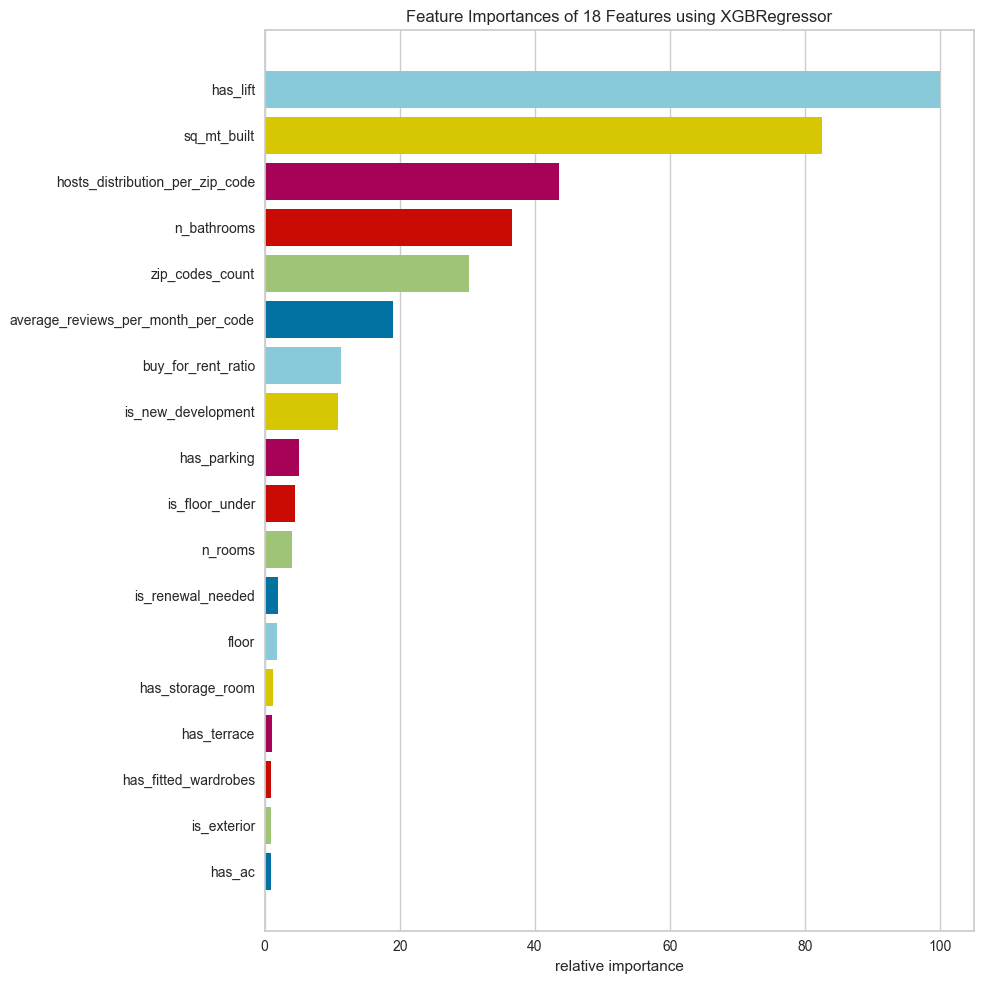

<Axes: title={'center': 'Feature Importances of 18 Features using XGBRegressor'}, xlabel='relative importance'>

In [41]:
from yellowbrick.features import FeatureImportances

fig,ax=plt.subplots(figsize=(10,10))
fi_viz=FeatureImportances(final_xgb)
fi_viz.fit(train_std_x,train_std_y)
fi_viz.poof()

In [42]:
print(final_xgb.score(test_std_x, test_std_y))

0.928852754239258


Ahora ejecutamos el mismo análisis para los datos transformados

In [43]:
# xgboost
xgb_model_bc = xgb.XGBRegressor()
xgb_model_bc_ = sklearn.model_selection.cross_validate(
    xgb_model_bc,
    train_std_x_bc,
    train_std_y_bc,
    scoring=scores_bc,
    cv=kfold_bc
)
print(
    f"{xgb_model_bc_['fit_time'].mean():.3f}s  R2: "
    f"{xgb_model_bc_['test_r2'].mean():.3f}  MAE: "
    f"{xgb_model_bc_['test_neg_mean_absolute_error'].mean()*-1:.3f}  RMSE: "
    f"{math.sqrt(xgb_model_bc_['test_neg_mean_squared_error'].mean()*-1):.3f}"
)

# hyperparameters optimization
params = {
    'max_depth': [5,10,20,40],
    'n_estimators': [10,20,40,80],
    'learning_rate': [0.1,0.01]
}
xgrid_bc = GridSearchCV(estimator=xgb.XGBRegressor(),           
                      param_grid=params, 
                      cv=5,
                      verbose=0) 
xgrid_bc.fit(train_std_x_bc, train_std_y_bc)
print(xgrid_bc.best_score_)
print(xgrid_bc.best_estimator_)
print(xgrid_bc.best_params_)

0.633s  R2: 0.944  MAE: 30394.684  RMSE: 59696.280
0.9406246675300247
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=80, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 80}


In [44]:
final_xgb_bc = xgb.XGBRegressor(
    max_depth=xgrid_bc.best_params_['max_depth'],
    n_estimators=xgrid_bc.best_params_['n_estimators']
)
final_xgb.fit(
    train_std_x_bc,
    train_std_y_bc
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=80, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

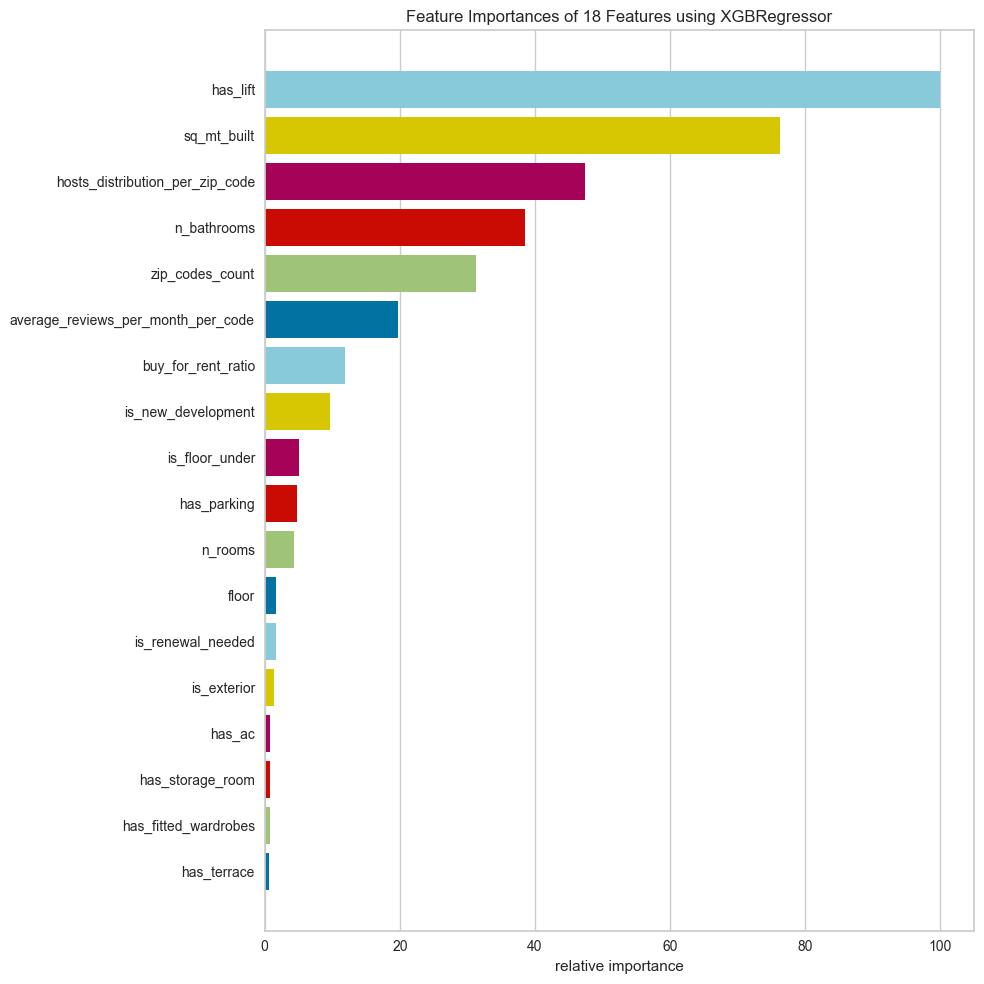

<Axes: title={'center': 'Feature Importances of 18 Features using XGBRegressor'}, xlabel='relative importance'>

In [45]:
fig,ax=plt.subplots(figsize=(10,10))
fi_viz=FeatureImportances(final_xgb_bc)
fi_viz.fit(train_std_x_bc,train_std_y_bc)
fi_viz.poof()

In [46]:
print(final_xgb_bc.score(test_std_x_bc, test_std_y_bc))

0.936373617136117


keras

In [47]:
# keras model -> lo usaremos en nuestro grid search
def build_model(input_shape=1, hidden_units=30, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(hidden_units, input_shape=(input_shape,), activation='relu'))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
        optimizer=SGD(clipnorm=1.0),
        
    )
    return model

# Train data previously generated
x_train = train_std_x_bc
y_train = train_std_y_bc
print(x_train.shape)
print(y_train.shape)

# Earlystopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a KerasRegressor based on the build_model function
keras_regressor = KerasRegressor(
    build_fn=build_model,
    input_shape=x_train.shape[1],
    hidden_units=x_train.shape[1],
    dropout_rate=0.2,
    epochs=10,
    batch_size=32
)

# Define the hyperparameters to search
param_grid = {
    # 'hidden_units': [32, 64, 128],
    'dropout_rate': [0.10, 0.20],
    'batch_size': [32, 64]
    }

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=keras_regressor,
    param_grid=param_grid,
    cv=3
)
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)



(6051, 18)
(6051,)


/var/folders/f4/pd0_vzm1045gp__jtf2z34wc0000gn/T/ipykernel_19149/2689695814.py:27: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_regressor = KerasRegressor(


Epoch 1/10
127/127 [==============================] - 2s 2ms/step - loss: 196287545344.0000
Epoch 2/10
127/127 [==============================] - 0s 2ms/step - loss: 196082270208.0000
Epoch 3/10
127/127 [==============================] - 0s 2ms/step - loss: 194953723904.0000
Epoch 4/10
127/127 [==============================] - 0s 2ms/step - loss: 191023792128.0000
Epoch 5/10
127/127 [==============================] - 0s 4ms/step - loss: 181392015360.0000
Epoch 6/10
127/127 [==============================] - 0s 2ms/step - loss: 161554890752.0000
Epoch 7/10
127/127 [==============================] - 0s 2ms/step - loss: 127863611392.0000
Epoch 8/10
127/127 [==============================] - 0s 2ms/step - loss: 82061262848.0000
Epoch 9/10
127/127 [==============================] - 0s 2ms/step - loss: 45827973120.0000
Epoch 10/10
64/64 [==============================] - 0s 2ms/step - loss: 29100193792.0000
Epoch 1/10
127/127 [==============================] - 1s 2ms/step - loss: 1918876549

In [48]:

best_regressor = KerasRegressor(
    build_fn=build_model,
    input_shape=x_train.shape[1],
    hidden_units=x_train.shape[1],
    dropout_rate=grid_search.best_params_['dropout_rate'],
    epochs=500,
    batch_size=grid_search.best_params_['batch_size']
)

best_regressor.fit(
    x_train,
    y_train,
    validation_split=0.1,
    callbacks=[early_stopping]
)

# Generate some test data for prediction
x_test = np.random.rand(10, 1)

# Predict the output for the test data using the best model
best_model = grid_search.best_estimator_.model
y_pred = best_model.predict(test_std_x_bc)
for y, p_y in zip(test_std_y_bc, y_pred):
    print('{}: {}'.format(y, p_y))


Epoch 1/500


/var/folders/f4/pd0_vzm1045gp__jtf2z34wc0000gn/T/ipykernel_19149/160854244.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  best_regressor = KerasRegressor(


171/171 [==============================] - 2s 7ms/step - loss: 195359604736.0000 - val_loss: 180410646528.0000
Epoch 2/500
171/171 [==============================] - 1s 3ms/step - loss: 194699919360.0000 - val_loss: 178815549440.0000
Epoch 3/500
171/171 [==============================] - 1s 3ms/step - loss: 190652923904.0000 - val_loss: 171239129088.0000
Epoch 4/500
171/171 [==============================] - 1s 3ms/step - loss: 176290775040.0000 - val_loss: 148919877632.0000
Epoch 5/500
171/171 [==============================] - 1s 5ms/step - loss: 141363822592.0000 - val_loss: 102965108736.0000
Epoch 6/500
171/171 [==============================] - 1s 3ms/step - loss: 84727693312.0000 - val_loss: 45507227648.0000
Epoch 7/500
171/171 [==============================] - 1s 3ms/step - loss: 41243664384.0000 - val_loss: 29965467648.0000
Epoch 8/500
171/171 [==============================] - 1s 4ms/step - loss: 32444651520.0000 - val_loss: 25374685184.0000
Epoch 9/500
171/171 [=============

48/48 [==============================] - 0s 3ms/step
MAE: 75343.7623874339
MSE: 12988270928.616196
RMSE: 113966.0955223798
VarScore: 0.8061003949301887


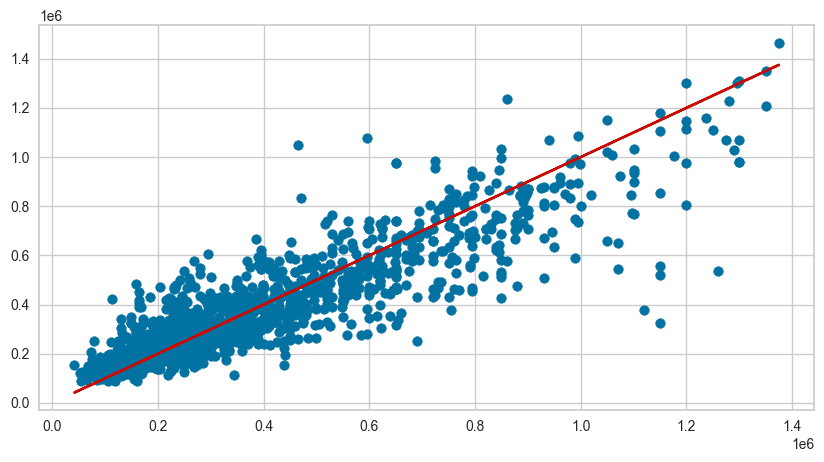

In [49]:
y_pred = best_regressor.predict(test_std_x_bc)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(test_std_y_bc, y_pred))  
print('MSE:', metrics.mean_squared_error(test_std_y_bc, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_std_y_bc, y_pred)))
print('VarScore:',metrics.explained_variance_score(test_std_y_bc,y_pred))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(test_std_y_bc,y_pred)
# Perfect predictions
plt.plot(test_std_y_bc,test_std_y_bc,'r')